In [25]:
from importlib.metadata import version
import json
import os
import urllib
import sys
import pprint
import torch
from torch.utils.data import Dataset, DataLoader
from functools import partial
import tiktoken
import torch.nn.functional as F
from pathlib import Path
import shutil
import time
import psutil
from tqdm import tqdm

In [2]:
pkgs = [
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.7.0
torch version: 2.4.0


In [3]:
sys.path.insert(0, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch04\Transformer_Implementation')
sys.path.insert(1, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch05\CustomGPT_Pretraining')
sys.path.insert(2, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch06\CustomGPT_ClassificationFT')
sys.path.insert(3, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch07\CustomGPT_InstructFineTune')
sys.path.insert(4, 'D:\LLM_Deeplearning.ai\SEBASTIAN_RASCHKA\LLMs-from-scratch-main\LLMs-from-scratch-main\ch02\Dataloader')

from text_generation import Text_Generation
from gpt2 import GPT2
from gpt_download import download_and_load_gpt2
from load_model_weights import *
from plot_metrics import Plots
from metrics import *
from gpt2_classificationFT import GPT2_ClassificationFineTune
from gpt2_instructDataFormat import *
from gpt2_datasetSplit import *
from gpt2_model_config import GPT2_ModelConfig

In [4]:
#The below function is taken as is from the repository of SR's 'BUild LLM From Scratch':
def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [5]:
pprint.pp(data[500])
print('----------------------')
pprint.pp(data[10])

{'instruction': "Translate 'Thank you very much' into Japanese.",
 'input': '',
 'output': "The Japanese translation of 'Thank you very much' is "
           "'どうもありがとうございます' (Dōmo arigatōgozaimasu).",
 'rejected': "The Japanese translation of 'Thank you very much' in a less "
             "polite tone is 'ありがとう' (Arigatou).",
 'chosen': "The Japanese translation of 'Thank you very much' is "
           "'どうもありがとうございます' (Dōmo arigatōgozaimasu)."}
----------------------
{'instruction': 'What is the contraction for "will not"?',
 'input': '',
 'output': 'The contraction for "will not" is "won\'t".',
 'chosen': 'The contraction for "will not" is actually "won\'t".',
 'rejected': 'The contraction for "will not" is "won\'t".'}


In [5]:
instruction_length , instruction_response = format_input_response(data[500],prompt_style='alpaca',inference=True)
print(instruction_response, '\n',instruction_length)
print('--------------------')
instruction_length , instruction_response = format_input_response(data[10],prompt_style='alpaca',inference=True)
print(instruction_response, '\n',instruction_length)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 Translate 'Thank you very much' into Japanese. 
 171
--------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What is the contraction for "will not"? 
 164


In [5]:
train_df, val_df, test_df = dataset_split(data=data, train_split=0.85, val_split=0.05, classify=False)
print('Train Data: ', len(train_df))
print('Val Data: ', len(val_df))
print('Test Data: ', len(test_df))

print('\nExample Train Data :', )
pprint.pp(train_df[500])

Train and Val Split Index ::  935 990
Train Data:  935
Val Data:  55
Test Data:  110

Example Train Data :
{'instruction': "Translate 'Thank you very much' into Japanese.",
 'input': '',
 'output': "The Japanese translation of 'Thank you very much' is "
           "'どうもありがとうございます' (Dōmo arigatōgozaimasu).",
 'rejected': "The Japanese translation of 'Thank you very much' in a less "
             "polite tone is 'ありがとう' (Arigatou).",
 'chosen': "The Japanese translation of 'Thank you very much' is "
           "'どうもありがとうございます' (Dōmo arigatōgozaimasu)."}


In [6]:
gpt2_config = GPT2_ModelConfig()
model_name = "gpt2_355M"
updatedGPT2_CONFIG = gpt2_config.load_model_config(model_name=model_name)
print('Model Config: ', updatedGPT2_CONFIG)

Model Config:  {'vocab_size': 50257, 'embedding_dimension': 1024, 'num_heads': 16, 'context_length': 1024, 'dropout': 0.0, 'qkv_bias': True, 'num_layers': 24}


In [7]:
class GPTCustomPreferenceDataset(Dataset):
    def __init__(self, data, tokenizer, prompt_style = 'alpaca'):
        super().__init__()
        self.data = data

        self.encoded_data = []

        for row in data:
            ins_length, input = format_input_response(row,prompt_style, inference=True)
            correct_response = row['chosen']
            wrong_response = row['rejected']

            encoded_input = tokenizer.encode(input)
            input_correctRes = f"{input}\n\n### Response:\n{correct_response}"
            input_wrongRes = f"{input}\n\n### Response:\n{wrong_response}"

            encoded_input_correctRes = tokenizer.encode(input_correctRes)
            encoded_input_wrongRes = tokenizer.encode(input_wrongRes)

            self.encoded_data.append({
                'input' : encoded_input,
                'correct_response': encoded_input_correctRes,
                'wrong_response' : encoded_input_wrongRes
            })

    def __getitem__(self, index):
        return self.encoded_data[index]
        
    def  __len__(self):
        return len(self.data)

In [8]:
def custom_collate_preference(batch, pad_token = 50256, device = 'cpu', 
                            max_seq_length = None, mask_instruction = False):
    

    batch_data = {
        'input': [],
        'correct_response': [],
        'wrong_response' : [],
        'correct_response_mask': [],
        'wrong_response_mask': []
    }

    max_length_batch = 0
    
    for key in ['correct_response', 'wrong_response']:
        key_length = max(len(row[key])+1 for row in batch)
        max_length_batch = max(max_length_batch, key_length)

    #For each entry in the current batch:
    for row in batch:
        prompt = torch.tensor(row['input'])
        batch_data['input'].append(prompt)

        for key in ['correct_response', 'wrong_response']:

            #Pad the sequence according to the max batch length across all the keys in that batch:
            input_response = row[key]
            input_response_padded = input_response + [pad_token] * (max_length_batch - len(input_response))

            #Create the mask for the padded tokens:
            mask = torch.ones(len(input_response_padded)).bool()

            #Make the mask values for all padded tokens to False:
            mask[len(input_response) : ] = False

            #Mask the input/prompt tokens:
            if mask_instruction:
                mask[ : prompt.shape[0]+2] = False

            batch_data[key+'_mask'].append(mask)
            batch_data[key].append(torch.tensor(input_response_padded))

    #Final Processing:
    for key in ['correct_response', 'wrong_response', 'correct_response_mask', 'wrong_response_mask']:

        #Stacking all tensors for a key in a batch together:
        tensor_stack = torch.stack(batch_data[key])

        #Truncate the tensor to the max_seq_length provided (Generally max_seq_length == context length of the model)
        if max_seq_length is not None:

            #Truncating the non batch dimension:
            tensor_stack = tensor_stack[ :, :max_seq_length]

            #Sending the batch tensor stack for this key to the device provided:
            batch_data[key] = tensor_stack.to(device)

    return batch_data

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

custom_collate_preference = partial(custom_collate_preference, device=device, pad_token = updatedGPT2_CONFIG['vocab_size'] -1,
                                    max_seq_length = updatedGPT2_CONFIG['context_length'], mask_instruction = True)

Device Available:  cuda


In [11]:
#Create the custom dataloader function that will call the GPTCustomPreferenceDataset class to create the dataset from the given text:
def GPTCustomPreferenceDataloader(data_file, pad_token = None, max_seq_length = None, batch_size=8, prompt_style = 'alpaca', 
                        shuffle=True, drop_last=True,num_workers=0):
    
    #Initializer the tokenizer
    tokenizer = tiktoken.get_encoding('gpt2')

    #Get the last token id of the tokenizer selected:
    if pad_token is None:
        pad_token = tokenizer.encode('<|endoftext|>', allowed_special='all')[0]

    torch.manual_seed(123)
    
    #Create the dataset with the tokenizer and the input file:
    dataset = GPTCustomPreferenceDataset(data = data_file, tokenizer=tokenizer, prompt_style = 'alpaca')

    #Create the dataloader with the dataset
    custom_dataloader = DataLoader(dataset,batch_size=batch_size, collate_fn=custom_collate_preference, 
                                   shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return custom_dataloader

In [12]:
def print_loader(loader):
    i=0
    print('Printing first 10 batches in the loader:: \n')
    for row in loader:
        print(row['correct_response'].shape, row['wrong_response'].shape)
        if i > 10:
            break
        else:
            i += 1

In [13]:
train_loader = GPTCustomPreferenceDataloader(train_df)
print('Number of training batches :: ', len(train_loader))

print('Train Loader ::')
print_loader(train_loader)
print('--------------------------')

val_loader = GPTCustomPreferenceDataloader(val_df)
print('Number of validation batches :: ', len(val_loader))

print('Validation Loader ::')
print_loader(val_loader)
print('--------------------------')

test_loader = GPTCustomPreferenceDataloader(test_df)
print('Number of test batches :: ', len(test_loader))

print('Test Loader ::')
print_loader(test_loader)
print('--------------------------')

Number of training batches ::  116
Train Loader ::
Printing first 10 batches in the loader:: 

torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 98]) torch.Size([8, 98])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 78]) torch.Size([8, 78])
--------------------------
Number of validation batches ::  6
Validation Loader ::
Printing first 10 batches in the loader:: 

torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 97]) torch.Size([8, 97])
--------------------------
Number of test batches ::  13
T

In [14]:
#Load the instruct fine-tuned model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)
model_fileName = model_name + '_instruct_FineTuned.pth'
print('Loaded Instruction FT model : ', model_fileName)

gpt2_preference = GPT2(updatedGPT2_CONFIG)
gpt2_preference.load_state_dict(torch.load(model_fileName, map_location=torch.device("cpu"), weights_only=True))
gpt2_preference.eval()

Device Available:  cuda
Loaded Instruction FT model :  gpt2_355M_instruct_FineTuned.pth


GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.0, inplace=Fa

In [15]:
torch.manual_seed(123)
_, input_text = format_input_response(train_df[10], inference=True)
print('Input Text:\n',input_text)
print('-----------------')

generate = Text_Generation(model=gpt2_preference, device='cpu', tokenizer_model='gpt2')
output_text = generate.text_generation(input_text = input_text, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
print(output_text)
response = (output_text[len(input_text):]).replace("### Response:", " ").replace('Response:', '').strip()
print('Generated Response :: ', response)
print('--------------------------')

prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""
print('2nd Input:')
print(prompt)
output_text = generate.text_generation(input_text = prompt, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
print(output_text)
response = (output_text[len(prompt)-1:]).replace("### Response:", " ").replace('Response:', '').strip()
print('Generated Response :: ', response)
print('--------------------------')


Input Text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What is the contraction for "will not"?
-----------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.### Instruction: What is the contraction for "will not"?### Response:The contraction for "will not" is "won't."
Generated Response ::  The contraction for "will not" is "won't."
--------------------------
2nd Input:
Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Below is an instruction that describes a task. Write a responsethat appropriately completes the request.### Instruction:Convert the active sentence to passive: 'The chef cooks the meal every day.'### Response:The meal is cooked every day by the chef.
Generated Response ::  The mea

#### Direct Preference Optimization LOSS:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=800px>

Image taken from the code repository of Sebastian Raschka's book 'Build LLM From Scratch'

In [16]:
#Loss loader function for DPO Loss:
def preference_loss_loader(policy_model, reference_model, device, dataloader, beta, num_batches = None):

    losses, rewards_correct, rewards_wrong = 0.0, 0.0, 0.0

    if len(dataloader) == 0:
        print('No batches/data in the dataloader..!')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(len(dataloader), num_batches)

    for i, batch in enumerate(dataloader):

        if i < num_batches:
            loss, rewards_correct_response, rewards_wrong_response = preference_loss_batch(batch, policy_model, reference_model, beta)

            losses += loss.item()
            rewards_correct += rewards_correct_response.item()
            rewards_wrong += rewards_wrong_response.item()

        else:

            break

    #Average loss and rewards for the loader
    losses /= num_batches
    rewards_correct /= num_batches
    rewards_wrong /= num_batches

    return losses, rewards_correct, rewards_wrong

In [17]:
def preference_loss_batch(batch, policy_model, reference_model, beta):

    policy_correct_response_probs = get_log_probability(policy_model, batch['correct_response'], batch['correct_response_mask'], model_type = None)

    policy_wrong_response_probs = get_log_probability(policy_model, batch['wrong_response'], batch['wrong_response_mask'], model_type = None)
    
    reference_correct_response_probs = get_log_probability(reference_model, batch['correct_response'], batch['correct_response_mask'], model_type = 'reference')

    reference_wrong_response_probs = get_log_probability(reference_model, batch['wrong_response'], batch['wrong_response_mask'], model_type = 'reference')

    dpo_loss, rewards_correct_response, rewards_wrong_response = dpo_loss_batch(policy_correct_probs = policy_correct_response_probs, policy_wrong_probs = policy_wrong_response_probs, 
                              reference_correct_probs = reference_correct_response_probs, reference_wrong_probs = reference_wrong_response_probs, 
                              beta = beta)
    
    return dpo_loss, rewards_correct_response, rewards_wrong_response

In [18]:
def get_log_probability(model, inputs, mask = None, model_type = None):

    if model_type == 'reference':

        #FROZEN MODEL, Hence no backprop:
        with torch.no_grad():

            logits = model(inputs)
    else:

        #Policy model, Hence we need to backprop:
        logits = model(inputs)
        
    logits = logits[ :, :-1, :]

    labels = inputs[ :, 1:].clone()

    log_probs = F.log_softmax(logits, dim = 1)

    #"labels" has a shape of <batch, num_tokens> and "log_probs" has a shape of <batch, num_tokens, vocab_size>, so we need to add an extra dimension at the very last 
    # in "labels" to perform the selection process. This additional dimension is thus added at the end by specifying "-1". We also need to remove this additional dimension
    # from the output log_probability tensor. So we use "squeeze(-1)" there.
    selected_log_probs = torch.gather(input= log_probs, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)

    if mask is not None:

        selected_mask = mask[:, 1:].clone()

        selected_log_probs = selected_log_probs * selected_mask

        avg_log_probs = selected_log_probs.sum(-1) / selected_mask.sum(-1)

        return avg_log_probs
    
    else:

        return selected_log_probs.mean(-1)


In [19]:
def dpo_loss_batch(policy_correct_probs, policy_wrong_probs, 
                   reference_correct_probs, reference_wrong_probs, 
                   beta= 0.1):
    

    policy_logits = policy_correct_probs - policy_wrong_probs
    reference_logits = reference_correct_probs - reference_wrong_probs

    logits = policy_logits - reference_logits

    scaled_logits = beta * logits

    dpo_loss = -F.logsigmoid(scaled_logits)

    #Calculate the reward gains for correct:
    rewards_correct_response = (policy_correct_probs - reference_correct_probs).detach()
    rewards_wrong_response = (policy_wrong_probs - reference_wrong_probs).detach()

    return dpo_loss.mean(), rewards_correct_response.mean(), rewards_wrong_response.mean()

In [20]:
def evaluate_model(policy_model, reference_model, train_dataloader, val_dataloader, beta, num_batches = None):

    policy_model.eval()
    result = {}

    with torch.no_grad():
        train_loss, train_rewards_correct, train_rewards_wrong = preference_loss_loader(policy_model, reference_model, device, 
                                                                                        train_dataloader, beta, num_batches = num_batches)
        val_loss, val_rewards_correct, val_rewards_wrong = preference_loss_loader(policy_model, reference_model, device, 
                                                                                  val_dataloader, beta, num_batches = num_batches)

    result = {
        'train_loss' : train_loss,
        'train_rewards_correct' : train_rewards_correct,
        'train_rewards_wrong' : train_rewards_wrong,
        'val_loss' : val_loss,
        'val_rewards_correct' : val_rewards_correct,
        'val_rewards_wrong' : val_rewards_wrong,
    }
    policy_model.train()

    return result 

In [22]:
def train_preference_model(policy_model, reference_model, optimizer, 
                           train_dataLoader, test_dataLoader,
                           num_epochs, eval_batchSize, eval_freq, 
                           start_context, max_new_tokens, beta = 0.1):
    
    tracking = {
        'train_loss' : [],
        'train_rewards_correct' : [],
        'train_rewards_wrong' : [],
        'val_loss' : [],
        'val_rewards_correct' : [],
        'val_rewards_wrong' : [],
        'tokens_seen' : []
    }

    tokens_tracked, global_step = 0, -1

    for epoch in range(num_epochs):
        
        policy_model.train()

        for i, batch in enumerate(train_dataLoader):

            optimizer.zero_grad()

            loss, rewards_correct, rewards_wrong = preference_loss_batch(batch = batch, policy_model= policy_model, 
                                                                                           reference_model = reference_model, beta = beta)
            
            loss.backward()
            optimizer.step()

            tokens_tracked += batch['correct_response'].numel()
            global_step += 1

            if (global_step % eval_freq) == 0:

                result = evaluate_model(policy_model = policy_model, reference_model = reference_model, 
                                        train_dataloader =  train_dataLoader, val_dataloader = test_dataLoader, 
                                        beta = beta, num_batches = eval_batchSize)
                

                tracking['train_loss'].append(result['train_loss'])
                tracking['train_rewards_correct'].append(result['train_rewards_correct'])
                tracking['train_rewards_wrong'].append(result['train_rewards_wrong'])
                tracking['val_loss'].append(result['val_loss'])
                tracking['val_rewards_correct'].append(result['val_rewards_correct'])
                tracking['val_rewards_wrong'].append(result['val_rewards_wrong'])
                tracking['tokens_seen'].append(tokens_tracked)

                train_reward_margin = result['train_rewards_correct'] - result['train_rewards_wrong']
                val_reward_margin = result['val_rewards_correct'] - result['val_rewards_wrong']

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {result['train_loss']:.3f}, Val loss {result['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        generate = Text_Generation(model=policy_model, device='cuda', tokenizer_model='gpt2')
        output_text = generate.text_generation(input_text = start_context, max_new_tokens= max_new_tokens, temp=0.0,top_k= None, eos_id=50256)
        print(output_text)


    return tracking

##### Examine one batch in detail:

In [23]:
for batch in train_loader:
    break

In [24]:
print(batch.keys())

dict_keys(['input', 'correct_response', 'wrong_response', 'correct_response_mask', 'wrong_response_mask'])


##### Preference Fine-Tuning with DPO Loss:

In [23]:
gpt2_reference = GPT2(updatedGPT2_CONFIG)
gpt2_reference.load_state_dict(
                                torch.load(model_fileName, map_location=torch.device("cpu"), weights_only=True)
                              )
gpt2_reference.eval();

gpt2_reference.to(device)
gpt2_preference.to(device)

GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.0, inplace=Fa

In [22]:
CUDA_LAUNCH_BLOCKING=1

In [28]:
with torch.no_grad():
    train_loss = preference_loss_batch(batch, gpt2_preference, gpt2_reference, beta = 0.1)
print('Intial Train Loss: ',train_loss)

torch.Size([8, 87])
torch.Size([8, 87])
torch.Size([8, 87])
torch.Size([8, 87])
Intial Train Loss:  (tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


In [32]:
#Calculate initial loss on the preference dataset:
torch.manual_seed(123)

res = evaluate_model(
    policy_model=gpt2_preference,
    reference_model=gpt2_reference,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    beta=0.1,
    num_batches=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_rewards_correct"] - res["train_rewards_wrong"])
print("Val reward margin:", res["val_rewards_correct"] - res["train_rewards_wrong"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


In [24]:
#Preference Fine-Tuning of GPT2 355M Model:

start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)

torch.manual_seed(123)
_, input_text = format_input_response(val_df[10], inference=True)
print('Input Text:\n',input_text)


optimizer = torch.optim.AdamW(gpt2_preference.parameters(), lr=5e-6, weight_decay=0.01)
epochs = 1

tracking_preferenceFT = train_preference_model(policy_model=gpt2_preference, reference_model= gpt2_reference, optimizer=optimizer, 
                                        train_dataLoader= train_loader, test_dataLoader= val_loader, 
                                        num_epochs=epochs, eval_batchSize= 5, eval_freq=5, start_context=input_text, max_new_tokens=100, beta=0.1)

end_time = time.time()
train_time =(end_time - start_time) / 60
print(f'-------------- Total Training Time : {train_time:.2f} minutes --------------')

Device Available:  cuda
Input Text:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What is the capital of Denmark?
Ep 1 (Step 000000): Train loss 0.686, Val loss 0.706, Train reward margins 1.094, Val reward margins 0.333
Ep 1 (Step 000005): Train loss 0.646, Val loss 0.703, Train reward margins 2.411, Val reward margins 1.517
Ep 1 (Step 000010): Train loss 0.683, Val loss 0.784, Train reward margins 1.015, Val reward margins 0.035
Ep 1 (Step 000015): Train loss 0.733, Val loss 0.729, Train reward margins 1.054, Val reward margins 1.524
Ep 1 (Step 000020): Train loss 0.665, Val loss 0.698, Train reward margins 1.606, Val reward margins 2.413
Ep 1 (Step 000025): Train loss 0.708, Val loss 0.677, Train reward margins 1.201, Val reward margins 1.840
Ep 1 (Step 000030): Train loss 0.697, Val loss 0.650, Train reward margins 1.035, Val reward margins 2.410
Ep 1 (Step 000035): Train loss 0.679, Val loss 0.731, Tra

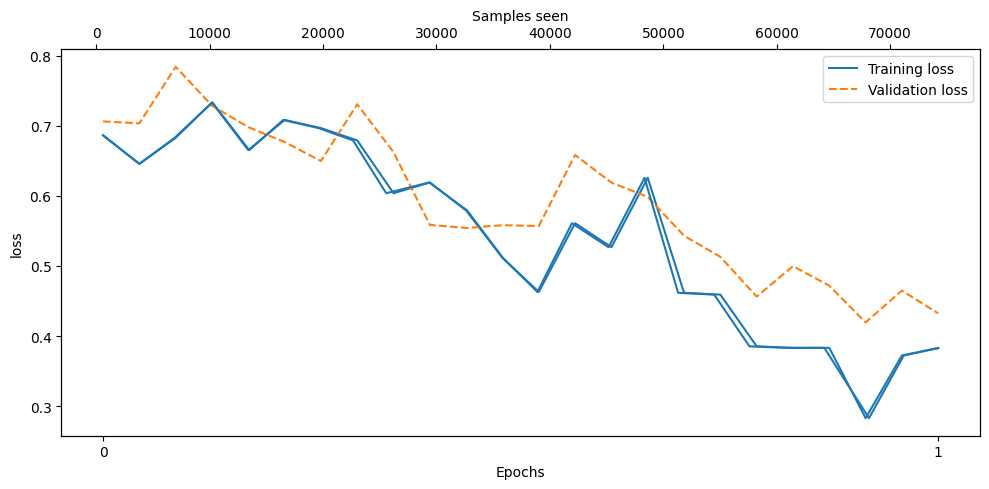

In [26]:
epochs_tensor = torch.linspace(0, epochs, len(tracking_preferenceFT['train_loss']))
plt = Plots(tracking_preferenceFT['tokens_seen'], epochs_tensor, tracking_preferenceFT['train_loss'], tracking_preferenceFT['val_loss'])
plt.plots('loss', 'preference_FineTune')

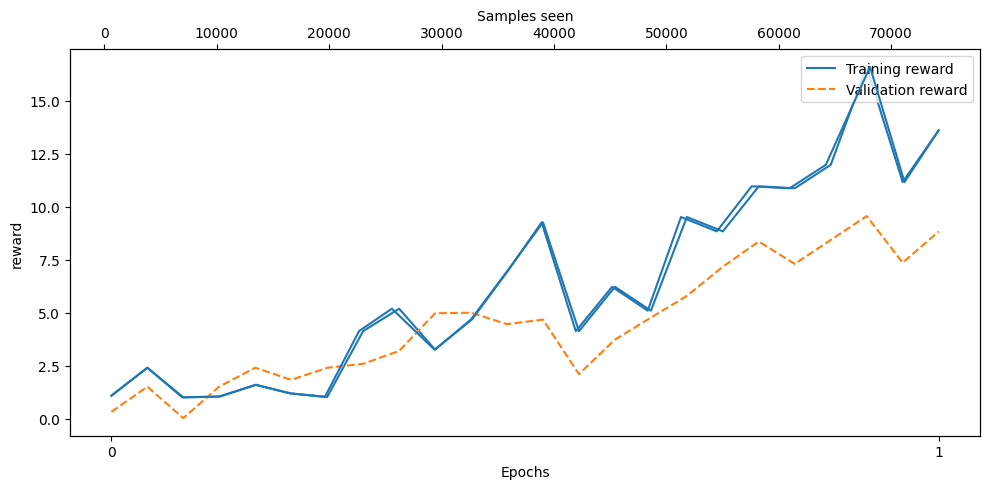

In [27]:
train_reward_margin = [x - y for x,y in zip(tracking_preferenceFT['train_rewards_correct'], tracking_preferenceFT['train_rewards_wrong'])]
val_reward_margin = [x - y for x,y in zip(tracking_preferenceFT['val_rewards_correct'], tracking_preferenceFT['val_rewards_wrong'])]

plt = Plots(tracking_preferenceFT['tokens_seen'], epochs_tensor, train_reward_margin, val_reward_margin)
plt.plots('reward', 'preference_FineTune')

In [25]:
#Save the preference fine-tuned gpt2 355M model:
save_model_fileName = model_name + '_preference_FineTuned.pth'
torch.save(gpt2_preference.state_dict(),save_model_fileName)
print('Preference FineTuned Model saved at {0} path.'.format(save_model_fileName))

Preference FineTuned Model saved at gpt2_355M_preference_FineTuned.pth path.


In [ ]:
#Load the preference fine-tuned model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device Available: ', device)
load_model_fileName = model_name + '_preference_FineTuned.pth'
print('Loaded Policy (Preference FT) model : ', load_model_fileName)

gpt2_preference = GPT2(updatedGPT2_CONFIG)
gpt2_preference.load_state_dict(torch.load(load_model_fileName, map_location=torch.device("cpu"), weights_only=True))

gpt2_preference.to(device)
gpt2_preference.eval();

Device Available:  cuda
Loaded Policy (Preference FT) model :  gpt2_355M_preference_FineTuned.pth


GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.0, inplace=Fa

In [8]:
model_fileName = model_name + '_instruct_FineTuned.pth'
print('Loaded Reference (Instruction FT) model : ', model_fileName)

gpt2_reference = GPT2(updatedGPT2_CONFIG)
gpt2_reference.load_state_dict(
                                torch.load(model_fileName, map_location=torch.device("cpu"), weights_only=True)
                              )
gpt2_reference.eval();

gpt2_reference.to(device)

Loaded Reference (Instruction FT) model :  gpt2_355M_instruct_FineTuned.pth


GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (token_dropout): Dropout(p=0.0, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attention_block): MultiHead_Attention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (feedForward): FeedForwardBlock(
        (block): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (layer_norm_attention): LayerNormalization()
      (layer_norm_feedforward): LayerNormalization()
      (dropout): Dropout(p=0.0, inplace=Fa

In [13]:

def analyse_preferenceTuning(data, policy_model, reference_model, n_records = None):

    torch.manual_seed(123)
    
    if n_records is None:
        n_records = len(data)
    
    for row in data[:n_records]:
        _, input_text = format_input_response(row, inference=True)

        generate = Text_Generation(model=policy_model, device=device, tokenizer_model='gpt2')
        output_text = generate.text_generation(input_text = input_text, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
        policy_output_text = (output_text[len(input_text) -2 :]).replace("### Response:", " ").replace('Response:', '').strip()

        generate = Text_Generation(model=reference_model, device=device, tokenizer_model='gpt2')
        output_text = generate.text_generation(input_text = input_text, max_new_tokens=35, temp=0.0,top_k= None, eos_id=50256)
        reference_output_text = (output_text[len(input_text) - 2:]).replace("### Response:", " ").replace('Response:', '').strip()

        print(input_text)
        print(f"\nCorrect response:\n>> {row['output']}")
        print(f"\nReference model response:\n>> {reference_output_text.strip()}")
        print(f"\nPolicy model response:\n>> {policy_output_text.strip()}")
        print("\n-------------------------------------\n")


In [14]:
analyse_preferenceTuning(val_df, policy_model = gpt2_preference, reference_model = gpt2_reference, n_records = 10)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 Rewrite the sentence using a simile.

### Input:
 The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a cheetah.

Policy model response:
>> The car is as fast as a cheetah.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> ## A thunderstorm is a type of storm that typically produces a strong wind and/or rain.

Policy model response:
>> ## A thunderstorm is a type of storm that typically produces a strong wind and/or rain.

-------------------------------------

Below is an instruction tha

In [15]:
analyse_preferenceTuning(test_df, policy_model = gpt2_preference, reference_model = gpt2_reference, n_records = 10)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 Explain the primary function of the human heart.

Correct response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Reference model response:
>> ## The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.

Policy model response:
>> ## The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
 Reword the following sentence to the future tense.

### Input:
 He is reading a novel inspired by his grandmother.

Correct response:
>> He will be reading a novel inspired by his grandmother.

Referen

In [ ]:
def save_model_response(data, generate):
    torch.manual_seed(123)

    for i, row in enumerate(data):
        _, input_text = format_input_response(row, inference=True)
        model_output = generate.text_generation(input_text = input_text, max_new_tokens=256, temp=0.0,top_k= None, eos_id=50256)
        model_response = model_output[len(input_text) -2 :].replace("### Response:", "").replace('Response:', '').replace('## :', '').strip()
        data[i]['model_response'] = model_response


    return data

In [17]:
#Save the policy model responses of the test data:
generate = Text_Generation(model=gpt2_preference, device=device, tokenizer_model='gpt2')
test_data_response = save_model_response(test_df, generate)

print('Example Test Data with model response::\n',test_data_response[0])

with open('gpt2_355M_preferenceData_response.json', "w") as file:
    json.dump(test_data_response, file, indent=4)

Example Test Data with model response::
 {'instruction': 'Explain the primary function of the human heart.', 'input': '', 'output': 'The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.', 'chosen': "I'd be happy to explain the primary function of the human heart for you. The main role of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.", 'rejected': 'The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.', 'model_response': '## The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.'}


In [20]:
with open('gpt2_355M_preferenceData_response.json', "r") as file:
    test_data_response = json.load(file)

print(test_data_response[0])

{'instruction': 'Explain the primary function of the human heart.', 'input': '', 'output': 'The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.', 'chosen': "I'd be happy to explain the primary function of the human heart for you. The main role of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.", 'rejected': 'The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.', 'model_response': '## The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.'}


In [22]:
for row in test_data_response:
    print('GT: ', row['output'])
    print('Generated: ', row['model_response'].replace('sponse:','').replace('## :', '').strip())
    print('------------------------------------')

GT:  The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.
Generated:  ## The primary function of the human heart is to pump blood to the brain and to supply oxygen to the body.
------------------------------------
GT:  He will be reading a novel inspired by his grandmother.
Generated:  He is reading a novel inspired by his grandmother.
------------------------------------
GT:  The government passed the law.
Generated:  The law was passed by the government.
------------------------------------
GT:  The confrontation was inevitable given the circumstances.
Generated:  ## The decision was inevitable.
------------------------------------
GT:  Opinion-based.
Generated:  The chocolate is the best dessert.
------------------------------------
GT:  young.
Generated:  ## An antonym of 'old' is 'young'.
------------------------------------
GT:  A synonym for 'hardworking' is 'diligen

#### OLLAMA Evaluation:

In [23]:
#The below three functions are taken as in from ch07.ipynb file of 'Build LLM from Scratch' Book by SR:

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [24]:
def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in many llama diets.
3. Grains: Oats, barley, and corn are common grains that llamas enjoy.
4. Fruits and vegetables: Llamas may also eat fruits like apples, carrots, and sweet potatoes, as well as leafy greens like kale and spinach.
5. Minerals: Llamas need access to minerals like calcium, phosphorus, and salt to stay healthy.

In the wild, llamas might eat:

* Leaves from trees and shrubs
* Bark (in some cases)
* Mosses and lichens
* Wild grasses and plants

Domesticated llamas, on the other hand, are often fed a diet that includes:

* Commercial llama feed or pellets
* Hay and grains
* Fresh fruits and vegetables as treats
* Minerals and supplements as needed

It's essential to provide lla

In [26]:
def generate_model_scores(data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(data):
        prompt = (
            f"Given the input `{format_input_response(entry, inference=True)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key].replace('sponse:','')}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data_response, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data_response)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

100%|██████████| 110/110 [08:15<00:00,  4.51s/it]

Number of scores: 110 of 110
Average score: 42.96



In [27]:
# Update the score records file:

model_score_dict = {
    load_model_fileName : sum(scores)/len(scores)
}

def write_json(new_data, filename):
    with open(filename,'r+') as file:
        
        file_data = json.load(file)
        
        file_data.update(new_data)
        
        # Sets file's current position at offset.
        file.seek(0)
        
        json.dump(file_data, file, indent = 4)
    
write_json(model_score_dict, filename = 'Model_Scores_Record.json')

In [ ]:
with open('Model_Scores_Record.json', "r") as file:
    test_data_score = json.load(file)

print(test_data_score)